# Thermometry Analysis for BEC Imaging

Import statements

In [11]:
!pip install matplotlib
!pip install scipy


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
  Using cached scipy-1.15.2-cp313-cp313-macosx_14_0_arm64.whl.metadata (61 kB)
Using cached scipy-1.15.2-cp313-cp313-macosx_14_0_arm64.whl (22.4 MB)

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from PIL import Image
import os
from ipywidgets import interact, widgets

Load and preprocess images.

In [13]:
def load_image(path):
    """
    Load an absorption image and convert to grayscale float array
    """
    image = Image.open(path).convert('L')
    return np.array(image).astype(float)

def crop_center(image, size=(200, 200)):
    """
    Crop center region of image to focus on atomic cloud
    """
    center = tuple(map(lambda x: x // 2, image.shape))
    h, w = size
    return image[center[0] - h//2 : center[0] + h//2,
                 center[1] - w//2 : center[1] + w//2]

Generate 1D profile for 2D image

In [19]:
def generate_1D_profile(image, axis=0):
    """
    Sum image along the given axis to create a 1D density profile
    axis=0 → vertical sum → profile along x
    axis=1 → horizontal sum → profile along y
    """
    return np.sum(image, axis=axis)

In [34]:
print(generate_1D_profile(crop_center(load_image('synthetic_TOF_image.png'))))

[ 2000.  2000.  2000.  2031.  2047.  2061.  2071.  2079.  2087.  2102.
  2138.  2158.  2176.  2190.  2237.  2265.  2285.  2338.  2370.  2423.
  2463.  2522.  2572.  2637.  2698.  2764.  2841.  2926.  3009.  3102.
  3197.  3306.  3417.  3538.  3657.  3793.  3938.  4084.  4244.  4412.
  4580.  4761.  4951.  5151.  5364.  5596.  5818.  6057.  6311.  6571.
  6843.  7114.  7409.  7708.  8013.  8332.  8662.  8986.  9332.  9677.
 10039. 10404. 10780. 11161. 11535. 11933. 12315. 12707. 13115. 13514.
 13914. 14306. 14714. 15098. 15501. 15897. 16281. 16661. 17032. 17396.
 17755. 18112. 18440. 18769. 19082. 19381. 19654. 19929. 20176. 20414.
 20631. 20839. 21015. 21172. 21314. 21435. 21536. 21597. 21671. 21699.
 21708. 21699. 21671. 21597. 21536. 21435. 21314. 21172. 21015. 20839.
 20631. 20414. 20176. 19929. 19654. 19381. 19082. 18769. 18440. 18112.
 17755. 17396. 17032. 16661. 16281. 15897. 15501. 15098. 14714. 14306.
 13914. 13514. 13115. 12707. 12315. 11933. 11535. 11161. 10780. 10404.
 10039

Define fit functions for TOF (time of flight, destructive) and in-situ (in place, nondestructive).

In [20]:
def gaussian(x, A, x0, sigma, offset):
    """
    Gaussian fit
    """
    return A * np.exp(-(x - x0)**2 / (2 * sigma**2)) + offset

def bimodal(x, A_T, x0, sigma_T, A_BEC, R, offset):
    """
    Bimodal fit = Gaussian (thermal) + Thomas-Fermi (condensate)
    """
    tf = np.clip(A_BEC * (1 - ((x - x0)/R)**2), 0, None)**1.5
    # gauss = A_T * np.exp(-(x - x0)**2 / (2 * sigma_T**2))
    gauss = gaussian(x, A_T, x0, sigma_T, 0)
    return tf + gauss + offset

Fit profile and calculate temperature.

In [21]:
def fit_profile(image, use_bimodal=False):
    """
    Fit either a Gaussian or a bimodal (BEC + thermal) profile
    """
    profile = generate_1D_profile(image)
    x = np.arange(len(profile))
    
    if use_bimodal:
        # Initial guess: [thermal amp, center, width, BEC amp, TF radius, offset]
        p0 = [np.max(profile), len(profile)//2, 20, np.max(profile)/2, 30, np.min(profile)]
        popt, pcov = curve_fit(bimodal, x, profile, p0=p0)
    else:
        # Initial guess: [amp, center, width, offset]
        p0 = [np.max(profile), len(profile)//2, 20, np.min(profile)]
        popt, pcov = curve_fit(gaussian, x, profile, p0=p0)

    return popt, pcov


kB = 1.381e-23 # Boltzmann constant
atom_mass_kg = 1.409e-25 # mass of Rb85

def calculate_temperature(sigma_pixels, pixel_size_um, time_ms):
    """
    Calculate temperature from thermal width using TOF: T = m*σ^2 / (kB * t^2)
    """
    sigma_m = sigma_pixels * pixel_size_um * 1e-6  # pixels → meters
    time_s = time_ms * 1e-3  # ms → seconds
    T = (atom_mass_kg * sigma_m**2) / (kB * time_s**2)
    return T  # [Kelvin]

def calculate_condensate_fraction(popt, use_bimodal=True):
    """
    Estimate condensate fraction from bimodal fit areas
    """
    if not use_bimodal: return None
    A_T, x0, sigma_T, A_BEC, R, offset = popt

    area_thermal = A_T * sigma_T * np.sqrt(2 * np.pi) # area under Gaussian (thermal)
    area_BEC = (16/15) * A_BEC * R # area under Thomas-Fermi (BEC)
    condensate_fraction = area_BEC / (area_BEC + area_thermal)
    return condensate_fraction

Full analysis

In [26]:
def analyze_image(filepath, pixel_size_um=5.0, time_ms=20.0, axis=0, use_bimodal=False):
    """
    Complete analysis: load image, fit profile, extract T and optionally condensate fraction
    """
    image = load_image(filepath)
    cropped = crop_center(image)
    profile = generate_1D_profile(cropped, axis=axis)
    x = np.arange(len(profile))
    #popt, _ = fit_profile(image, use_bimodal=use_bimodal)
    popt, _ = fit_profile(x, profile, use_bimodal=use_bimodal)
    #if use_bimodal: sigma_T = popt[2] # thermal width from Gaussian part
    #else: sigma_T = popt[2] # thermal width from pure Gaussian fit
    sigma_T = popt[2]
    # Calculate temperature
    T = calculate_temperature(sigma_T, pixel_size_um, time_ms)

    # (Optionally) calculate Condensate Fraction
    condensate_fraction = None
    if use_bimodal:
        condensate_fraction = calculate_condensate_fraction(popt, use_bimodal=use_bimodal)
    
    # Plot
    plt.figure(figsize=(8,5))
    plt.plot(x, profile, 'b.', label='Data')
    if use_bimodal:
        plt.plot(x, bimodal(x, *popt), 'r-', label='Bimodal Fit')
    else:
        plt.plot(x, gaussian(x, *popt), 'r-', label='Gaussian Fit')
    plt.xlabel('Pixel')
    plt.ylabel('Integrated Optical Density')
    plt.legend()
    plt.title(f'Temperature: {T*1e9:.1f} nK')
    plt.grid()
    plt.show()
    
    return T, condensate_fraction


In [ ]:
def analyze_image_array(image_array, pixel_size_um=5.0, time_ms=20.0, axis=0, use_bimodal=False):
    """
    Analyze a given grayscale image array, fit profile, extract temperature,
    and optionally extract condensate fraction.
    """
    cropped = crop_center(image_array)
    profile = generate_1D_profile(cropped, axis=axis)
    x = np.arange(len(profile))

    if use_bimodal:
        p0 = [np.max(profile), len(profile)//2, 20, np.max(profile)/2, 30, np.min(profile)]
        popt, _ = curve_fit(bimodal, x, profile, p0=p0)
        sigma_T = popt[2]
    else:
        p0 = [np.max(profile), len(profile)//2, 20, np.min(profile)]
        popt, _ = curve_fit(gaussian, x, profile, p0=p0)
        sigma_T = popt[2]

    T = calculate_temperature(sigma_T, pixel_size_um, time_ms)
    condensate_fraction = calculate_condensate_fraction(popt) if use_bimodal else None

    # Plot result
    plt.figure(figsize=(8, 5))
    plt.plot(x, profile, 'b.', label='Data')
    fit_func = bimodal if use_bimodal else gaussian
    plt.plot(x, fit_func(x, *popt), 'r-', label='Fit')
    plt.xlabel('Pixel')
    plt.ylabel('Integrated OD')
    plt.title(f'Temperature: {T*1e9:.1f} nK')
    plt.legend()
    plt.grid()
    plt.show()

    return T, condensate_fraction

Analyze an absorption image

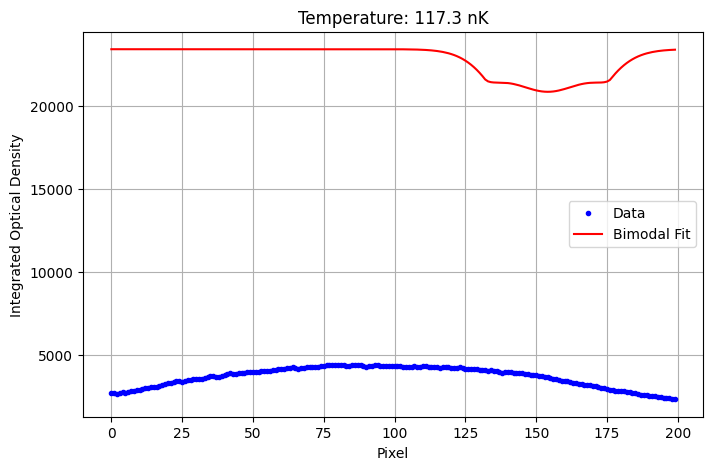

1.1732675503549289e-07
Extracted Temperature: 117.33 nK
Condensate Fraction: -2.74%


In [38]:
T, condensate_fraction = analyze_image(
    filepath='ss.png', 
    pixel_size_um=5.0,  # pixel size of camera
    time_ms=20.0,       # TOF time in milliseconds
    axis=0,             # sum vertically to get x profile
    use_bimodal=True    # fit BEC + thermal cloud
)
print(T)
print(f"Extracted Temperature: {T*1e9:.2f} nK")
if condensate_fraction is not None:
    print(f"Condensate Fraction: {condensate_fraction*100:.2f}%")

Testing camera

In [2]:
!pip install opencv-python
!pip install pyserial

  Using cached numpy-2.2.5-cp313-cp313-macosx_14_0_arm64.whl.metadata (62 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 1.9 MB/s eta 0:00:000:00:01m eta 0:00:01
Using cached numpy-2.2.5-cp313-cp313-macosx_14_0_arm64.whl (5.1 MB)

[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip


If the temperature extraction doesn't work, the image-saving should and then I'll have test images to work with.

This assumes that the Arduino shutter has been set up in a similar way to the code in 'shutter.ino', to send a signal when it opens.

In [ ]:
num = 0

In [ ]:
def capture_image_and_analyze(
    serial_port='/dev/ttyACM0',
    baudrate=9600,
    camera_index=0,
    exposure_value=-6,
    tof_delay_ms=20,
    pixel_size_um=5.0,
    use_bimodal=True,
    save_path=f'images/tof_image_{num}.png'
):
    """
    Wait for Arduino shutter signal, capture grayscale image with ELP HD USB camera,
    save and analyze temperature via TOF thermometry.
    """
    # Set up serial communication with Arduino
    ser = serial.Serial(serial_port, baudrate, timeout=2)
    time.sleep(2)

    # Set up camera
    cap = cv2.VideoCapture(camera_index)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
    cap.set(cv2.CAP_PROP_AUTO_EXPOSURE, 0.25) # manual exposure
    cap.set(cv2.CAP_PROP_EXPOSURE, exposure_value)
    time.sleep(1.0)

    print("Waiting for SHUTTER_OPEN signal from Arduino...")

    while True:
        if ser.in_waiting:
            line = ser.readline().decode('utf-8').strip()
            print(f"Arduino says: {line}")
            if line == "SHUTTER_OPEN":
                ret, frame = cap.read()
                if not ret:
                    print("Failed to capture frame.")
                    break

                gray = frame if len(frame.shape) == 2 else cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
                cv2.imwrite(save_path, gray)
                print(f"Image saved to {save_path}")

                T, frac = analyze_image_array(
                    gray,
                    pixel_size_um=pixel_size_um,
                    time_ms=tof_delay_ms,
                    use_bimodal=use_bimodal
                )
                print(f"Extracted Temperature: {T*1e9:.2f} nK")
                if frac is not None:
                    print(f"Condensate Fraction: {frac*100:.2f}%")
                break

    cap.release()
    ser.close()

In [ ]:
capture_image_and_analyze(
    serial_port='/dev/ttyACM0', # adjust as needed
    baudrate=9600,
    camera_index=0,
    exposure_value=-6,
    tof_delay_ms=20,
    pixel_size_um=5.0,
    use_bimodal=False,
    save_path='tof_image.png'
)

New

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from PIL import Image

# Load PNGs
atom = np.array(Image.open("atom.png").convert("L")).astype(float)
ref = np.array(Image.open("ref.png").convert("L")).astype(float)
dark = np.array(Image.open("dark.png").convert("L")).astype(float)

# Compute optical density (OD)
I_atom = atom - dark
I_ref = ref - dark
I_atom[I_atom <= 1] = 1
I_ref[I_ref <= 1] = 1
OD = np.log(I_ref / I_atom)

# Fit a 2D Gaussian: A * exp(-((x-x0)^2/2sx^2 + (y-y0)^2/2sy^2)) + offset
def gaussian_2d(XY, A, x0, y0, sx, sy, offset):
    x, y = XY
    return A * np.exp(-((x - x0)**2 / (2 * sx**2) + (y - y0)**2 / (2 * sy**2))) + offset

# Generate grid
ny, nx = OD.shape
x = np.linspace(-nx/2, nx/2, nx)
y = np.linspace(-ny/2, ny/2, ny)
X, Y = np.meshgrid(x, y)
XY = np.vstack([X.ravel(), Y.ravel()])
OD_flat = OD.ravel()

# Fit
# [A, x0, y0, sx, sy, offset]
p0 = [1.0, 0.0, 0.0, 30.0, 30.0, 0.05]
popt, _ = curve_fit(gaussian_2d, XY, OD_flat, p0=p0)
OD_fit = gaussian_2d((X, Y), *popt).reshape(ny, nx)

# Plot results
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].imshow(OD, cmap="viridis", origin="lower")
axs[0].set_title("OD Image")
axs[1].imshow(OD_fit, cmap="viridis", origin="lower")
axs[1].set_title("Fitted Gaussian")
axs[2].imshow(OD - OD_fit, cmap="bwr", origin="lower")
axs[2].set_title("Residual")
plt.tight_layout()
plt.show()

# Show fit results
labels = ["Amplitude", "x0", "y0", "sigma_x", "sigma_y", "offset"]
for name, val in zip(labels, popt):
    print(f"{name:10s} = {val:.2f}")
